In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

import os
import numpy as np

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

from modules.util import getdata

import ica

In [2]:
file_name = os.listdir('./data')
dir_list = []
for name in file_name[0:5]:
    dir_list.append('./data/'+name)
num_of_img = len(dir_list)
# num_of_img = 3
resize = 128

array_list=[]

for img_dir in dir_list:
    image = Image.open(img_dir)
    image = np.array(ImageOps.grayscale(image))
    image = cv2.resize(image, (resize, resize))
#     image = torch.from_numpy(image).float().flatten()
    image = np.expand_dims(image.flatten(), axis=0)
    array_list.append(image)

img_concate = np.concatenate(array_list)
np.random.seed(1)

# D = np.diag(2**np.array([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7], dtype=float))

# B = ortho_group.rvs(dim=num_of_img)
# A = B @ D
# A = np.random.normal(0, 1, size=(num_of_img,num_of_img))
A = np.random.rand(num_of_img,num_of_img)
mixture = A@img_concate

print(A, img_concate.shape, sep='\n')

print('condition number:', np.linalg.cond(A))

[[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
  1.46755891e-01]
 [9.23385948e-02 1.86260211e-01 3.45560727e-01 3.96767474e-01
  5.38816734e-01]
 [4.19194514e-01 6.85219500e-01 2.04452250e-01 8.78117436e-01
  2.73875932e-02]
 [6.70467510e-01 4.17304802e-01 5.58689828e-01 1.40386939e-01
  1.98101489e-01]
 [8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01
  8.76389152e-01]]
(5, 16384)
condition number: 23.66792577690414


In [3]:
np.random.seed(1004)
n_dist = num_of_img
# numbatch=100
# batchsize = int(35000/numbatch)
sub_shape = n_dist

A = np.random.rand(n_dist,n_dist)
# A = np.random.normal(0, 1,(n_dist,n_dist))
# D = np.diag(np.array([1,100,200,300,400,500,600,700,800,900], dtype=float))

# B = ortho_group.rvs(dim=n_dist)
# A = B @ D
print('condition number:', np.linalg.cond(A))
X_list = []
# X_list.append(np.random.standard_t(5, size=(1,16384)))
# X_list.append(np.random.laplace(scale=scale, size=(1,16384)))
# X_list.append(np.random.exponential(scale, size=(1,16384)))
for i in range(n_dist):
    scale = np.random.randint(5,15)
#     print(scale)
#     X_list.append(np.random.beta(0.5,0.5,(1,16384)))
#     X_list.append(np.random.randn(1, 35000))
    X_list.append(np.random.laplace(scale=scale, size=(1,16384)))
#     X_list.append(np.random.standard_t(1, size=(1,16384)))
#     X_list.append(np.random.exponential(scale, size=(1,16384)))
#     X_list.append(np.random.chisquare(scale, size=(1,16384)))
    
dist_c = np.concatenate(X_list)


# unif = np.random.uniform(1,2,(10,numbatch))
# for i in range(numbatch):
#     dist_c[:,batchsize*i:batchsize*(i+1)] *= unif[:,i:i+1]

mixture = A@dist_c

condition number: 14.837229715325632


In [4]:
IPT = torch.from_numpy(mixture).to(torch.float32)
IPT = IPT - IPT.mean(axis=1).unsqueeze(1)

In [20]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, input_size, bias=False),
#             nn.ReLU(),
#             nn.Linear(128, input_size),
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.Linear(input_size, 128),
#             nn.ReLU(),
            nn.Linear(input_size, input_size, bias=False),
#             nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded




In [23]:
# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
input_size = num_of_img  # Size of MNIST images (28x28 = 784)
encoding_size = 3  # Size of the compressed representation
learning_rate = 0.1
batch_size = 1024
num_epochs = 1000

# Load the MNIST dataset
dataset = getdata(IPT)
# sampler = SequentialSampler(dataset)
sampler = RandomSampler(dataset)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

# Create the autoencoder model
model = Autoencoder(input_size, encoding_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=learning_rate,
                             eps=10e-4,
                             weight_decay = 1e-4,
                            )

scheduler = CosineAnnealingLR(optimizer, T_max = num_epochs)

In [24]:

# Train the autoencoder
for epoch in range(num_epochs):
    for _, batch_data in enumerate(train_loader):
        batch_data = batch_data.to(device)

        # Forward pass
        output = model(batch_data)
        loss = criterion(output, batch_data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Print the loss every few epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()/len(train_loader.sampler):.4f}")

Epoch [2/1000], Loss: 0.0004
Epoch [4/1000], Loss: 0.0001
Epoch [6/1000], Loss: 0.0000
Epoch [8/1000], Loss: 0.0000
Epoch [10/1000], Loss: 0.0000
Epoch [12/1000], Loss: 0.0000
Epoch [14/1000], Loss: 0.0000
Epoch [16/1000], Loss: 0.0000
Epoch [18/1000], Loss: 0.0000
Epoch [20/1000], Loss: 0.0000


KeyboardInterrupt: 

In [11]:
a = model.encoder[0].weight.data.cpu()@IPT

In [12]:
x_white, white, dewhite = ica.pca_whiten(mixture, num_of_img)

In [13]:
a = a.detach().numpy()
b = x_white

In [14]:
varr = np.corrcoef(a,b,rowvar=True)

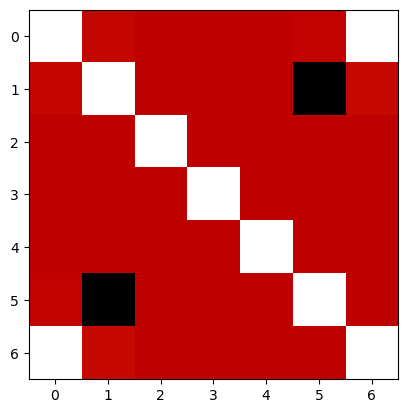

In [15]:
plt.imshow(varr, cmap='gist_heat')

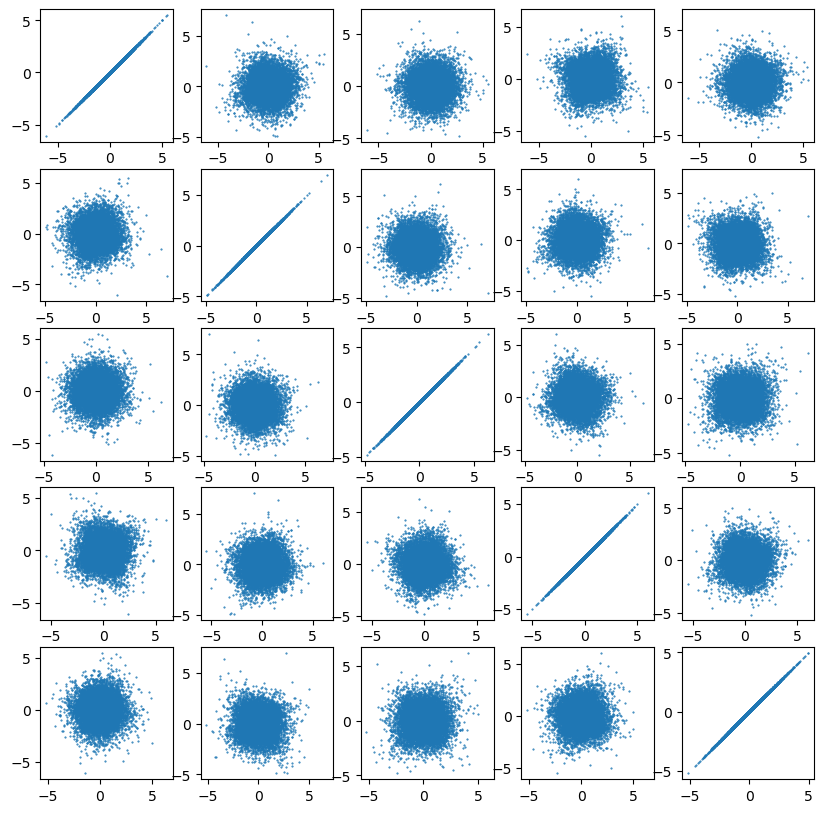

In [16]:
%matplotlib inline
plt.figure(figsize=(10,10))

sub_shape = 5

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(b[i], b[j], '.', ms=1)
        plt.axis('square')

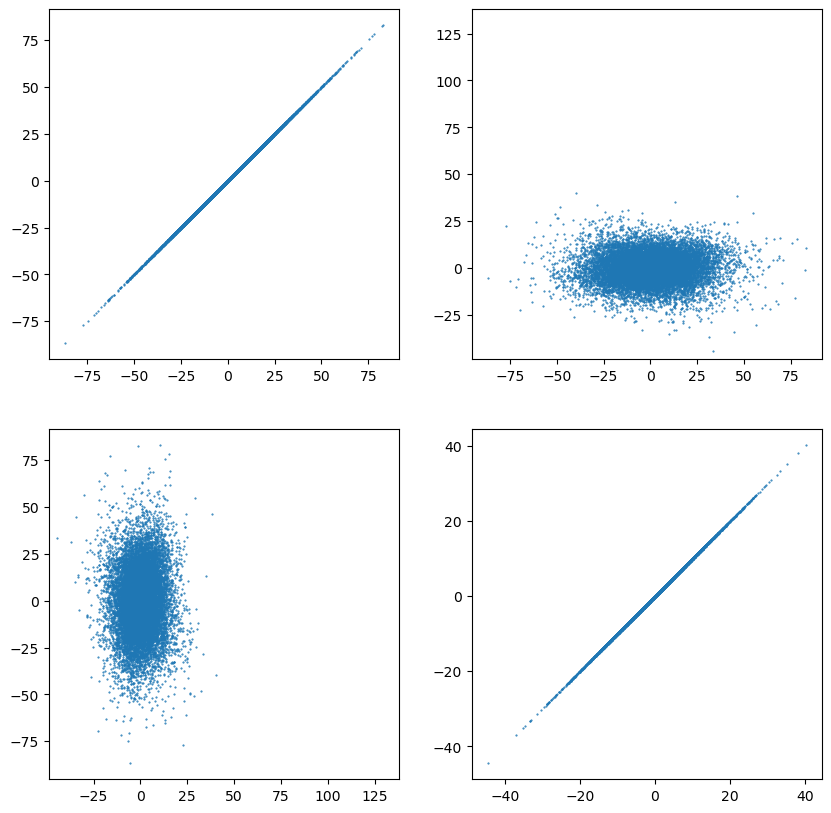

In [18]:
%matplotlib inline
plt.figure(figsize=(10,10))

sub_shape = 2

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(a[i], a[j], '.', ms=1)
        plt.axis('square')

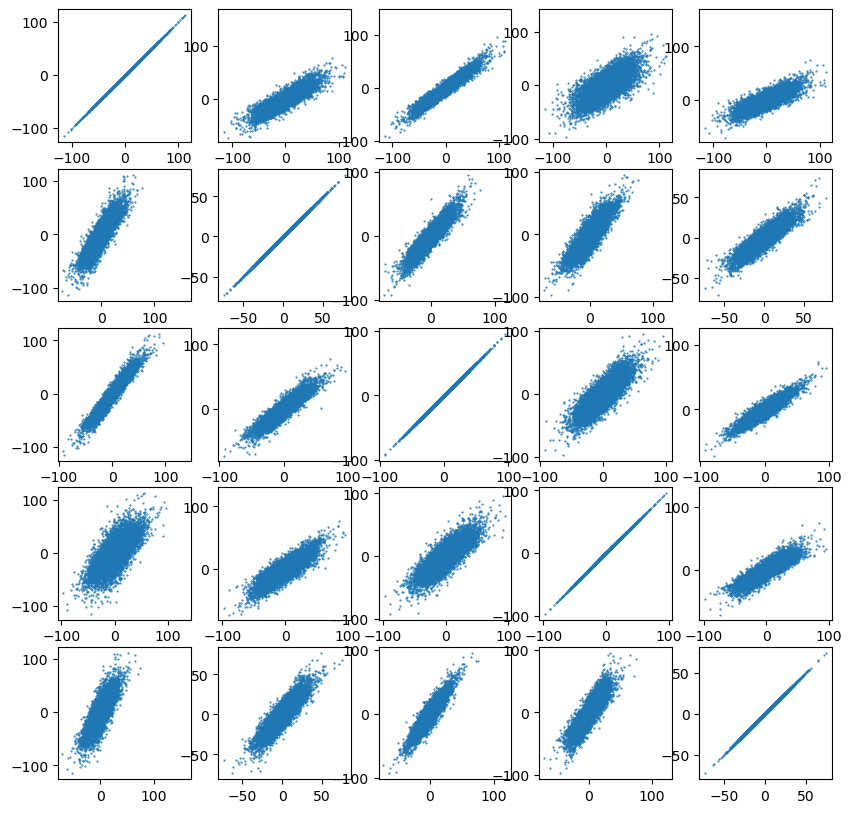

In [19]:
%matplotlib inline
plt.figure(figsize=(10,10))

sub_shape = 5

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(mixture[i], mixture[j], '.', ms=1)
        plt.axis('square')